# 欢迎使用易通星云故障预测与健康管理建模向导

本文件指导用户逐步使用健康模型包对装备进行健康建模。

首先需要描述[装备健康管理的分析框架](https://mp.weixin.qq.com/s/S5qN4IphJVw2qIPwK8Cbkg)。 

一些概念:
* 状态估计: 通过传感器采集到的可观测量，对系统状态（可能是不可直接观测的量）进行估算的过程。
* 指标预测: 随着时间的推移以及外部发生事件的影响而对系统状态演进趋势的预测过程。

易通星云故障预测与健康管理软件架构图

![软件架构图](https://github.com/lvyv/prog_algs/blob/dev/demo/images/softwareAT.png?raw=true)
* `状态预测器` - 对系统进行状态估计的工具。
* `指标预测器` - 对系统未来状态进行预测的工具。
* `不确定性因素` - 对不确定性因素进行数据表征的工具。

## 1. 不确定性因素 - 概率分布表征

观测数据受到不确定性因素的影响，在被用于状态估计和指标预测的时候会产生不同的结果，这正是同样的装备，同样的工况却可能反映出不同健康状态的原因。
为仿真现实世界的不确定性数据的影响，需要使用最能描述现实数据特征的数据类型。
不确定数据包含如下类型：
* 多元正太分布的采样数据
* 未加权采样数据
* 单值数据


（1）使用不确定性数据示例——创建采样空间

In [12]:
from prog_algs.uncertain_data import UnweightedSamples
samples = UnweightedSamples([{'x': 1, 'v': 2}, {'x': 2, 'v': -2}, {'x': 3, 'v': 0}])

（2）使用不确定性数据示例——生成采样数据

In [13]:
print(samples.sample(10)) # 10 samples

UnweightedSamples([{'x': 1, 'v': 2}, {'x': 1, 'v': 2}, {'x': 2, 'v': -2}, {'x': 2, 'v': -2}, {'x': 3, 'v': 0}, {'x': 1, 'v': 2}, {'x': 2, 'v': -2}, {'x': 3, 'v': 0}, {'x': 1, 'v': 2}, {'x': 3, 'v': 0}])


（3）使用不确定性数据示例——采样数据的计算和存取

In [14]:
samples = samples + 5
print(samples)
samples -= 3
print(samples)
print(samples.keys())
print(samples.key('x'))

UnweightedSamples([{'x': 6, 'v': 7}, {'x': 7, 'v': 3}, {'x': 8, 'v': 5}])
UnweightedSamples([{'x': 3, 'v': 4}, {'x': 4, 'v': 0}, {'x': 5, 'v': 2}])
dict_keys(['x', 'v'])
[3, 4, 5]


（4）使用不确定性数据示例——采样数据的统计量

In [15]:
print('mean', samples.mean)
print('median', samples.median)
print('covariance', samples.cov)
print('size', samples.size)

mean {'x': 4.0, 'v': 2.0}
median {'x': 5, 'v': 2}
covariance [[ 1. -1.]
 [-1.  4.]]
size 3


## 2. 状态估计

状态估计是给定模型和传感器数据，算法给出系统状态估计值，一般情况下，随着新的传感器数据持续更新，状态估计也持续进行，不断给出新的系统状态。
下例为电驱无人机的电池管理系统BHM用于预测电池电量还能够支持多长时间飞行的示例。电池驱动无人机与燃油驱动的无人机的最大差异是前者的容量在电池的生命周期内会持续减少。

<img src="https://github.com/lvyv/prog_algs/blob/dev/demo/images/uav.jpg?raw=true" width="680"/>

![功率与转速对照图](https://github.com/lvyv/prog_algs/blob/dev/demo/images/throttle-power.png?raw=true)
![电池的等效电路模型](https://github.com/lvyv/prog_algs/blob/dev/demo/images/lipo-ECM.png?raw=true)
![电池等效电路模型的微分方程组](https://github.com/lvyv/prog_algs/blob/dev/demo/images/lipo-equation.png?raw=true)
![电池输出功率实际与预测对照](https://github.com/lvyv/prog_algs/blob/dev/demo/images/predict.png?raw=true)

In [16]:
from prog_models.models import BatteryCircuit
from prog_algs.state_estimators import UnscentedKalmanFilter

第一步、初始化模型，根据初始条件构建状态估计器。

In [17]:
m = BatteryCircuit()
x0 = m.initialize()

# Turn into a distribution - this represents uncertainty in the initial state
from prog_algs.uncertain_data import MultivariateNormalDist
from numpy import diag
INITIAL_UNCERT = 0.05  # Uncertainty in initial state (%)
# Construct covariance matrix (making sure each value is positive)
cov = diag([max(abs(INITIAL_UNCERT * value), 1e-9) for value in x0.values()])
x0 = MultivariateNormalDist(x0.keys(), x0.values(), cov)

# Construct State estimator
est = UnscentedKalmanFilter(m, x0)

第二步、使用状态估计器评估系统状态。

Prior State: {'tb': 18.95, 'qb': 7856.3254, 'qcp': 0.0, 'qcs': 0.0}
	SOC:  1.0
Posterior State: {'tb': 32.18602883009096, 'qb': 7842.897323682542, 'qcp': 0.20004182642728852, 'qcs': 0.20004181361989068}
	SOC:  0.9982733603809364


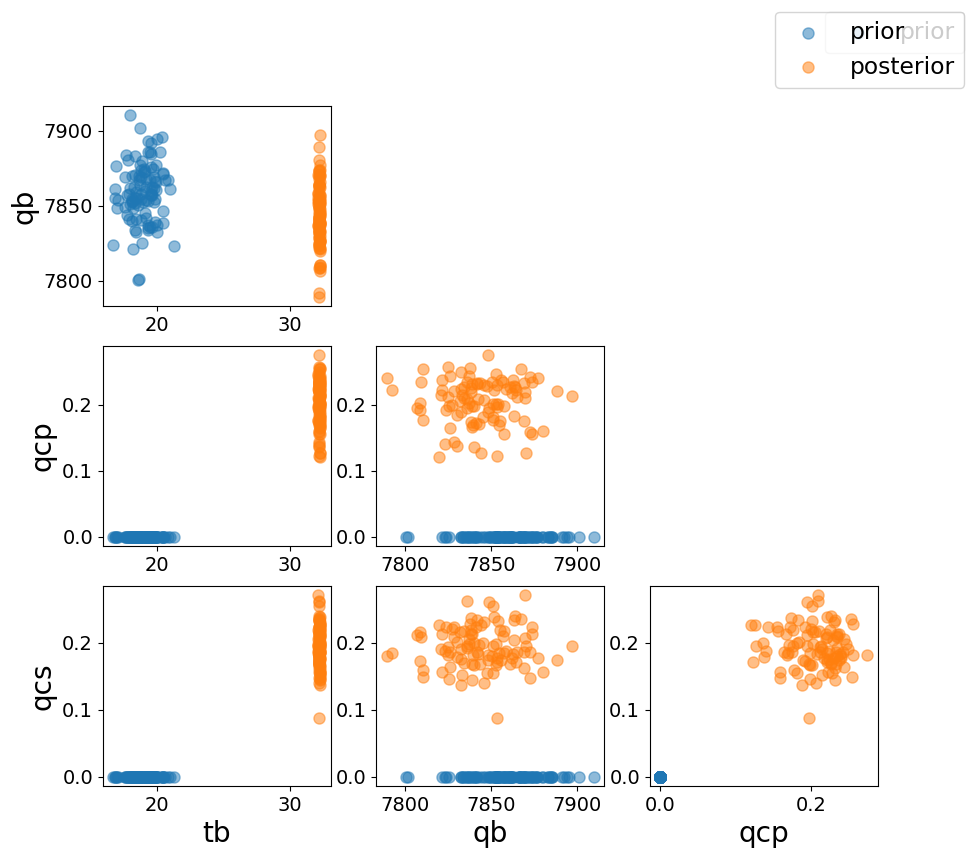

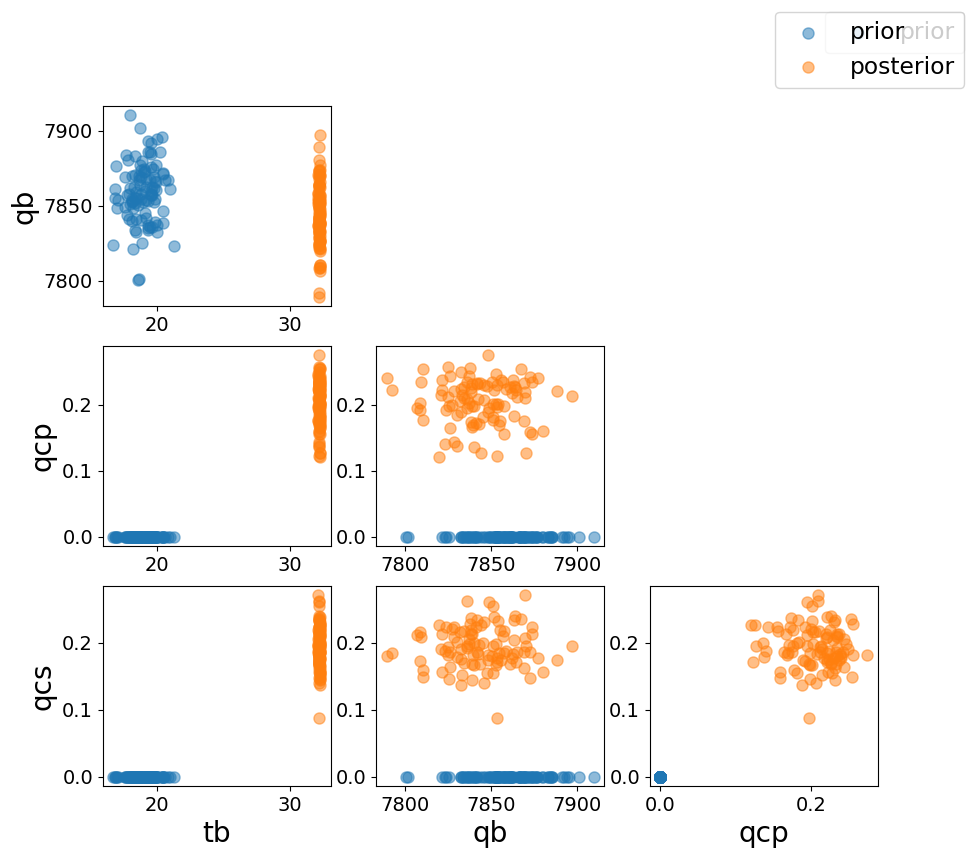

In [18]:
print("Prior State:", est.x.mean)
print('\tSOC: ', m.event_state(est.x.mean)['EOD'])
fig = est.x.plot_scatter(label='prior')

t = 0.1
u = m.InputContainer({'i': 2})
example_measurements = m.OutputContainer({'t': 32.2, 'v': 3.915})
est.estimate(t, u, example_measurements)

print("Posterior State:", est.x.mean)
print('\tSOC: ', m.event_state(est.x.mean)['EOD'])
est.x.plot_scatter(fig= fig, label='posterior')

## 3. 指标预测示例

应用上一步训练的状态估计器，并输入未来工况，将能够预测未来的系统状态和某些事件何时发生，比如放电结束事件（EOD）。

第一步、导入预测器，在示例中使用蒙特卡洛预测器。

In [11]:
from prog_algs.predictors import MonteCarlo

第二步、用前面训练的模型来初始化预测器。

In [12]:
mc = MonteCarlo(m)

第三步、定义未来负荷和初始状态。未来负载是简单的分段函数，初始状态是模型的输出。

In [13]:
x = est.x  # The state estimate

def future_loading(t, x={}):
    # Variable (piece-wise) future loading scheme 
    if (t < 600):
        i = 2
    elif (t < 900):
        i = 1
    elif (t < 1800):
        i = 4
    elif (t < 3000):
        i = 2
    else:
        i = 3
    return m.InputContainer({'i': i})

第四步、使用预测器进行预测。

In [14]:
mc_results = mc.predict(x, future_loading, dt=0.25, n_samples=20)

The predict function returns predictions of future inputs, states, outputs, and event_states at each save point. For sample-based predictors like the monte carlo, these can be accessed like an array with the format `[sample #][time]` so that `mc_results.states[m][n]` corresponds to the state for sample `m` at time `mc_results.times[m][n]`. Alternately, use the method `snapshot` to get a  single point in time. e.g., 

    `state = mc_results.states.snapshot(3)`

In this case the state snapshot corresponds to time `mc_results.times[3]`. The snapshot method returns type UncertainData. 

The `predict` method also returns Time of Event (ToE) as a type UncertainData, representing the predicted time of event (for each event predicted), with uncertainty.

Next, let's use the metrics package to analyze the ToE

In [ ]:
print("\nEOD Predictions (s):")
print('\tPortion between 3005.2 and 3005.6: ', mc_results.time_of_event.percentage_in_bounds([3005.2, 3005.6]))
print('\tAssuming ground truth 3005.25: ', mc_results.time_of_event.metrics(ground_truth = 3005.25))
from prog_algs.metrics import prob_success 
print('\tP(Success) if mission ends at 3005.25: ', prob_success(mc_results.time_of_event, 3005.25))

These analysis methods applied to ToE can also be applied to anything of type UncertainData (e.g., state snapshot). 

You can also visualize the results in a variety of different ways. For example, state transition

In [ ]:
fig = mc_results.states.snapshot(0).plot_scatter(label = "t={:.0f}".format(int(mc_results.times[0])))
for i in range(1, 4):
    index = int(len(mc_results.times)/4*i)
    mc_results.states.snapshot(index).plot_scatter(fig=fig, label = "t={:.0f}".format(mc_results.times[index]))
mc_results.states.snapshot(-1).plot_scatter(fig = fig, label = "t={:.0f}".format(int(mc_results.times[-1])))

Or time of event (ToE)

In [ ]:
fig = mc_results.time_of_event.plot_hist()

Note, for this event, there is only one event (End of Discharge). Many models have multiple events that can be predicted. For these models, ToE for each event is returned and can be analyzed.

Alternately, a specific event (or events) can be specified for prediction. See `examples.predict_specific_event` for more details.

Frequently the prediction step is run periodically, less often than the state estimator step

## 4. 扩展 - 添加新的状态估计器

New state estimators can be created by extending the state_estimator interface. As an example lets use a really dumb state estimator that adds random noise each step - and accepts the state that is closest. 

First thing we need to do is import the StateEstimator parent class

In [ ]:
from prog_algs.state_estimators.state_estimator import StateEstimator

Next we select how state will be represented. In this case there's no uncertainty- it's just one state, so we represent it as a scaler. Import the appropriate class

In [ ]:
from prog_algs.uncertain_data import ScalarData

Now we construct the class, implementing the functions of the state estimator template (`state_estimator_template.py`)

In [ ]:
import random 

class BlindlyStumbleEstimator(StateEstimator):
    def __init__(self, model, x0):
        self.m = model
        self.state = x0

    def estimate(self, t, u, z):
        # Generate new candidate state
        x2 = {key : float(value) + 10*(random.random()-0.5) for (key,value) in self.state.items()}

        # Calculate outputs
        z_est = self.m.output(self.state)
        z_est2 = self.m.output(x2)

        # Now score them each by how close they are to the measured z
        z_est_score = sum([abs(z_est[key] - z[key]) for key in self.m.outputs])
        z_est2_score = sum([abs(z_est2[key] - z[key]) for key in self.m.outputs])

        # Now choose the closer one
        if z_est2_score < z_est_score: 
            self.state = x2

    @property
    def x(self):
        return ScalarData(self.state)


Great, now let's try it out using the model from earlier. with an initial state of all 0s. It should slowly converge towards the correct state

In [ ]:
x0 = {key: 0 for key in m.states}
se = BlindlyStumbleEstimator(m, x0)

for i in range(25):
    u = m.InputContainer({'i': 0})
    z = m.OutputContainer({'t': 18.95, 'v': 4.183})
    se.estimate(i, u, z)
    print(se.x.mean)
    print("\tcorrect: {'tb': 18.95, 'qb': 7856.3254, 'qcp': 0, 'qcs': 0}")

## 5. 扩展 - 添加新的指标预测器

与上一节类似，可以继承Predictor类来扩展设计一个新的指标预测器，可以参考 `predictor_template.py` 文件，从头开始编写一个指标预测器。

## 6. 结论
本向导只是入门教程，更多的例子参考 `examples/` 目录的示例, 示例包括:
* `examples.basic_example` : 故障预测基础示例。 
* `examples.benchmarking_example` : 故障预测算法基线指标。
* `examples.eol_event` : 首次用户关注事件发生时间预测。
* `examples.measurement_eqn_example` : 观测值与输出事件的关联方程示例。 
* `examples.new_state_estimator_example` : 创建新的状态估计器示例。
* `examples.playback` : 复盘数据分析。
* `examples.predict_specific_event` : 预报用户感兴趣的事件的示例。
* `examples.thrown_object_example` : 抛出异常的方式进行事件播报的示例。
* `examples.utpredictor` : 简单的指标预测示例。

感谢关注。

版权所有 © 2021 易通星云（北京）科技发展有限公司.